In [1]:
import array
import random
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def sigmoid(x: np.array) -> np.array:
    return 1 / (1 + np.exp(-x))


def der_sigmoid(x: np.array) -> np.array:
    return np.array([sigmoid(c) * (1 - sigmoid(c)) for c in x])


def mse(x: np.array, y: np.array) -> np.array:
    return np.power(x - y, 2)


def der_mse(x: np.array, y: np.array) -> np.array:
    return 2 * (x - y)


def derivative(f):
    if f == sigmoid:
        return der_sigmoid
    if f == mse:
        return der_mse


class Layer:
    def __init__(self, shape: tuple):
        self.W = np.random.rand(shape[0], shape[1]) * 2 - 1
        self.b = np.random.rand(shape[0]) * 2 - 1


class Dense(Layer):
    pass


class Model:
    def __init__(self, activation, loss_func):
        self.layers = []
        self.a = []
        self.h = []
        self.activation = activation
        self.loss_func = loss_func
        self.eta = 1

    def add(self, layer: Layer):
        self.layers.append(layer)

    def forward_prop(self, x):
        self.a = []
        self.h = [x]
        for layer in self.layers:
            self.a.append(np.dot(layer.W, self.h[-1]) + layer.b)
            self.h.append(self.activation(self.a[-1]))
        return self.h[-1]

    def back_prop(self, grad):
        g = grad
        for k in range(len(self.layers) - 1, -1, -1):
            g = np.multiply(g, derivative(self.activation)(self.a[k]))
            self.layers[k].b -= self.eta * g
            gr_W = np.outer(g, np.transpose(self.h[k]))
            g = np.dot(np.transpose(self.layers[k].W), g)
            self.layers[k].W -= self.eta * gr_W

    def fit(self, train_x, train_y, epochs: int):
        for epoch in range(epochs):
            x = train_x.to_numpy()
            y = train_y.to_numpy()
            for i, row in enumerate(x):
                res = self.forward_prop(row)
                err = self.loss_func(res, y[i])
                grad = derivative(self.loss_func)(res, y[i])
                self.back_prop(grad)

    def predict(self, samples):
        res = []
        s = samples.to_numpy()
        for sample in s:
            res.append(self.forward_prop(sample))
        return res

In [4]:
def normalize(d: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    return (d - d.min()) / (d.max() - d.min()), d.min(), d.max()


def denormalize(d: np.array, d_min: float, d_max: float) -> np.array:
    return np.dot(d, (d_max - d_min)) + d_min


def regression():
    targets = ['G_total', 'КГФ']
    data = pd.read_csv("C:\\Users\\User\\PycharmProjects\\tpns\\lab1\\data.csv", parse_dates=["Дата"], decimal=',',
                       sep=';')
    x = data.iloc[:, ~data.columns.isin(targets)]
    x['year'] = x['Дата'].apply(lambda row: row.year)
    x = x.loc[:, x.columns != 'Дата']
    means = {i: x[i].mean() for i in x}
    x = x.fillna(value=means)
    g_total_fill = pd.DataFrame()
    g_total_fill['G_total'] = (800 * x['Дебит газа'] + x['Дебит ст. конд.'] * x['Ro_c'] + 1000 * x['Дебит воды']) / 24 / 3600
    g_total_fill['КГФ'] = [random.random() * 120 + 140 for i in data.index]
    y = data.iloc[:, data.columns.isin(targets)]
    y = y.fillna(value=g_total_fill)
    x_train = x.iloc[:3 * len(data.index) // 4]
    y_train = y.iloc[:3 * len(data.index) // 4]
    x_test = x.iloc[3 * len(data.index) // 4:]
    y_test = y.iloc[3 * len(data.index) // 4:]
    x_train, x_min, x_max = normalize(x_train)
    y_train, y_min, y_max = normalize(y_train)
    x_test, x_min, x_max = normalize(x_test)
    model = Model(sigmoid, mse)
    model.add(Dense((20, 28)))
    model.add(Dense((8, 20)))
    model.add(Dense((2, 8)))
    model.fit(x_train, y_train, 10)
    res = model.predict(x_test)
    g_total_res = [r[0] for r in res]
    kgf_res = [r[1] for r in res]
    g_total_predicts = denormalize(g_total_res, y_min['G_total'], y_max['G_total'])
    kgf_predicts = denormalize(kgf_res, y_min['КГФ'], y_max['КГФ'])
    g_total_err = mse(g_total_predicts, y_test['G_total'])
    kgf_err = mse(kgf_predicts, y_test['КГФ'])
    print("G_total rmse:", sqrt(sum(g_total_err) / len(g_total_err)))
    print("КГФ rmse: ", sqrt(sum(kgf_err) / len(kgf_err)))

regression()

C:\Users\User\AppData\Local\Temp\ipykernel_17556\296327456.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['year'] = x['Дата'].apply(lambda row: row.year)


G_total rmse: 0.5463557962220597
КГФ rmse:  26.23522438004188


threshold 0.0: acc = 0.4672575086164451, precision = 0.4672575086164451, recall = 1.0
threshold 0.05: acc = 0.9158050221565731, precision = 0.8473214285714286, recall = 1.0
threshold 0.1: acc = 0.9926144756277696, precision = 0.9844398340248963, recall = 1.0
threshold 0.15: acc = 0.9950763170851797, precision = 0.9895724713242962, recall = 1.0
threshold 0.2: acc = 0.9955686853766618, precision = 0.9906054279749478, recall = 1.0
threshold 0.25: acc = 0.9960610536681438, precision = 0.9916405433646813, recall = 1.0
threshold 0.3: acc = 0.9960610536681438, precision = 0.9916405433646813, recall = 1.0
threshold 0.35: acc = 0.9960610536681438, precision = 0.9916405433646813, recall = 1.0
threshold 0.4: acc = 0.9965534219596258, precision = 0.9926778242677824, recall = 1.0
threshold 0.45: acc = 0.9965534219596258, precision = 0.9926778242677824, recall = 1.0
threshold 0.5: acc = 0.9965534219596258, precision = 0.9926778242677824, recall = 1.0
threshold 0.55: acc = 0.9965534219596258, precisi

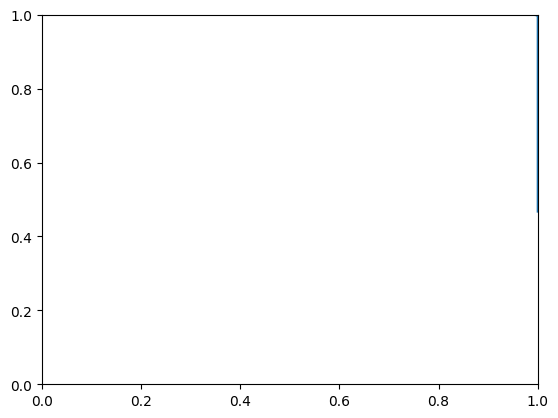

In [6]:
def encoding(data: pd.DataFrame) -> pd.DataFrame:
    data_out = data.copy()
    for col in data_out:
        data_out[col] = data_out[col].apply(lambda x: ord(x) - ord('a'))
    return (data_out - data_out.min()) / (data_out.max() - data_out.min())


def precision_recall(predicts: array, labels: pd.DataFrame, threshold: float) -> (float, float, float):
    preds = [1 if c[0] > threshold else 0 for c in predicts]
    tp = sum([l == 1 and preds[i] == 1 for i, l in enumerate(labels)])
    fp = sum([l == 0 and preds[i] == 1 for i, l in enumerate(labels)])
    tn = sum([l == 0 and preds[i] == 0 for i, l in enumerate(labels)])
    fn = sum([l == 1 and preds[i] == 0 for i, l in enumerate(labels)])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    return precision, recall, acc


def classification():
    targets = [0]
    data = pd.read_csv("C:\\Users\\User\\PycharmProjects\\lab2\\agaricus-lepiota.csv", header=None)
    data = encoding(data)
    data = data.sample(frac=1)
    x_train = data.iloc[:3*len(data.index) // 4, ~data.columns.isin(targets)]
    y_train = data.iloc[:3*len(data.index) // 4, data.columns.isin(targets)]
    x_test = data.iloc[3*len(data.index) // 4:, ~data.columns.isin(targets)]
    y_test = data.iloc[3*len(data.index) // 4:, data.columns.isin(targets)]
    model = Model(sigmoid, mse)
    model.add(Dense((16, 20)))
    model.add(Dense((8, 16)))
    model.add(Dense((1, 8)))
    model.fit(x_train, y_train, 12)
    thresholds = [i / 20 for i in range(20)]
    predicts = model.predict(x_test)
    precisions = []
    recalls = []
    for t in thresholds:
        pr = precision_recall(predicts, y_test[0].to_numpy(), t)
        precisions.append(pr[0])
        recalls.append(pr[1])
        print(f'threshold {t}: acc = {pr[2]}, precision = {pr[0]}, recall = {pr[1]}')
    plt.plot(recalls, precisions)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()


classification()